In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import prod

In [2]:
sns.set_theme(style="white")

In [113]:
dims = 5,20
halo = (2,2),(2,2)
prob = '2d5pt'
dtype = np.float32
nodes = 4
mpi = False

In [116]:
devito = np.fromfile(f"{prob}.devito.data", dtype).reshape(dims)
orig = np.fromfile(f"{prob}.input.data", dtype).reshape([(x + h[0] + h[1]) for x, h in zip(dims, halo)])[2:-2,2:-2]

if mpi:
    # load data and re-order
    stencil_raw = np.fromfile(f"{prob}.stencil.data", dtype)[0:prod(dims)]
    #stencil = stencil_raw.reshape(dims)
    stencil = np.zeros(dims)
    local_dims = dims[0], dims[1] // nodes
    for i in range(nodes):
        local = stencil_raw[(i * prod(local_dims)):((i+1) * prod(local_dims))].reshape(local_dims)
        stencil[:,(i * local_dims[1]):((i+1) * local_dims[1])] = local
else:
    stencil = np.fromfile(f"{prob}.stencil.data", dtype).reshape([(x + h[0] + h[1]) for x, h in zip(dims, halo)])[2:-2,2:-2]


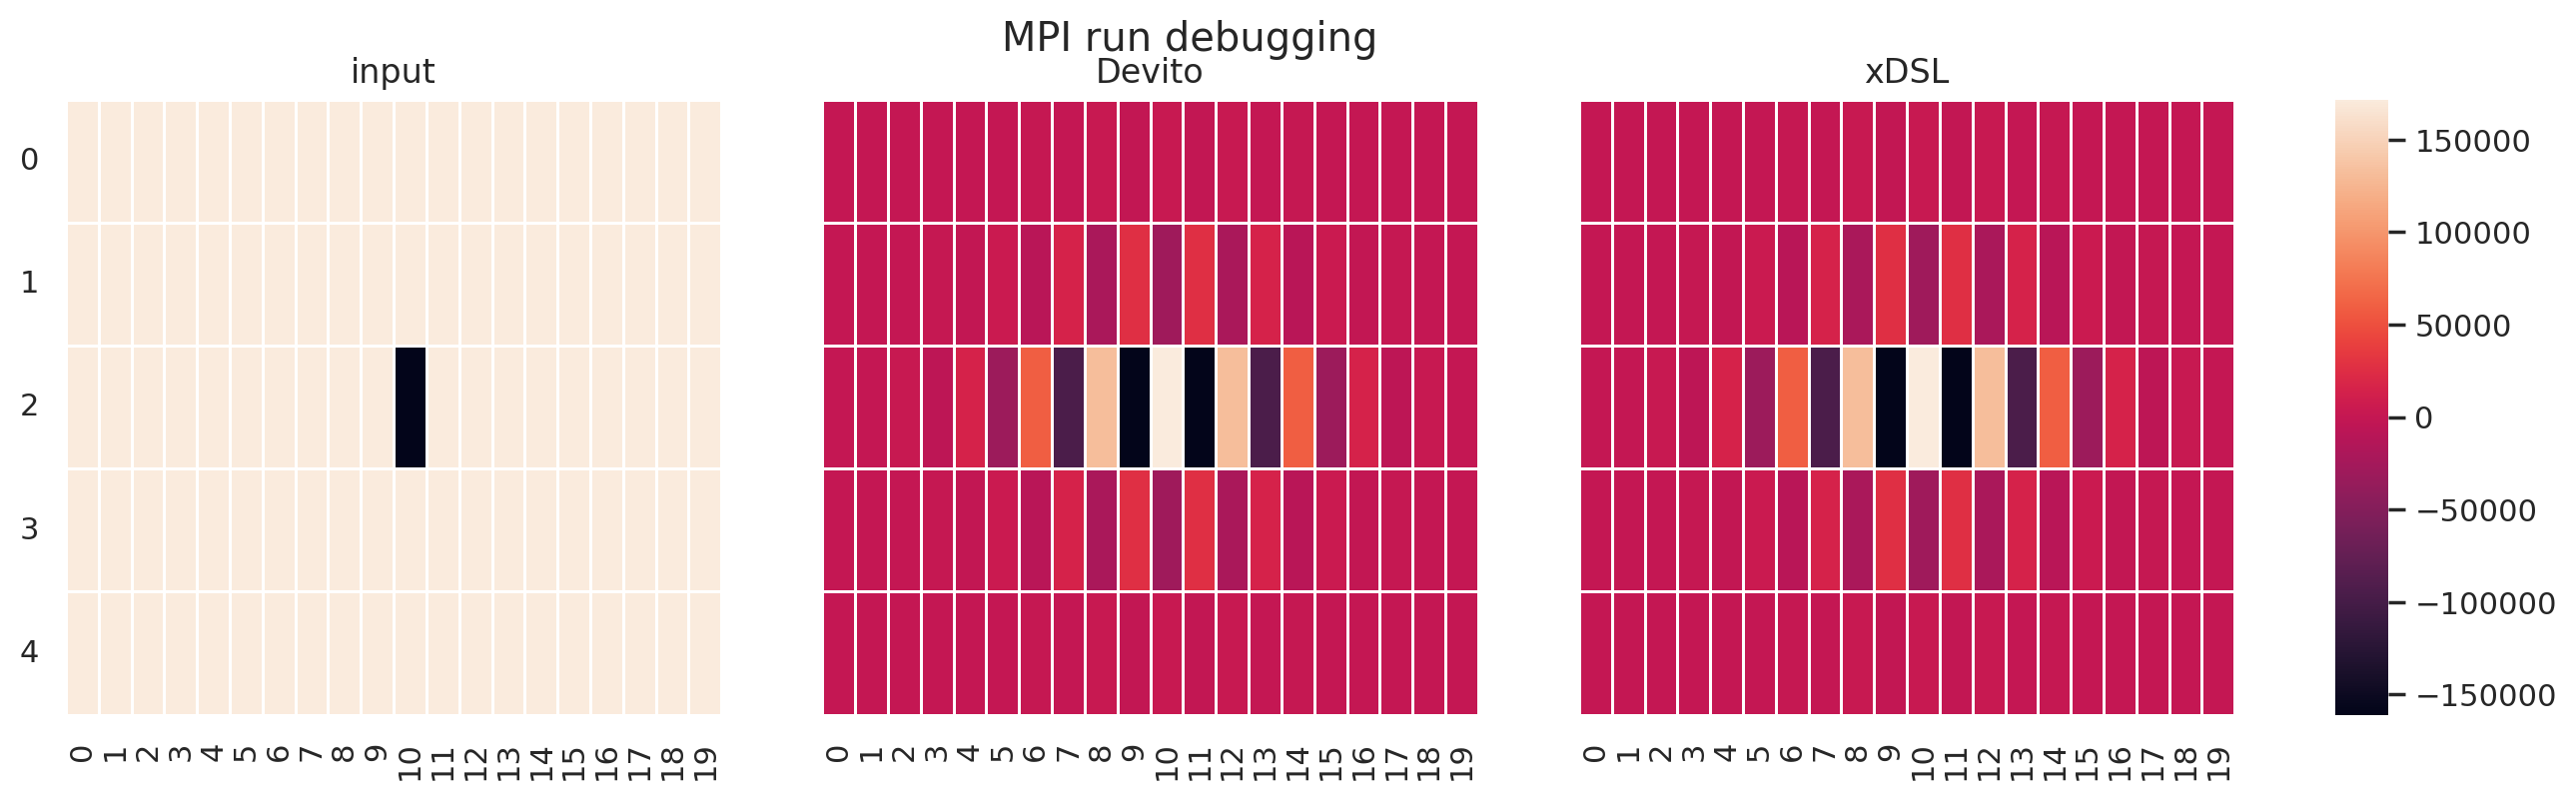

In [117]:
f,(ax1,ax2,ax3, cbar_ax) = plt.subplots(1,4, 
            gridspec_kw={'width_ratios':[1,1,1,0.08]}, figsize=(15, 4), dpi=200)
ax1.get_shared_y_axes().join(ax2,ax3)

m, M = min(devito.min(), stencil.min()), max(devito.max(), stencil.max())

titles = iter(['input', 'Devito', 'xDSL'])

kwargs = dict(vmin=m, vmax=M, linewidth=0.5 if dims[1] < 40 else 0) #

for g, yticks in ((sns.heatmap(orig, linewidth=0.5 if dims[0] < 40 else 0, ax=ax1, cbar=False), True),
          (sns.heatmap(devito,**kwargs, ax=ax2, cbar=False), False),
          (sns.heatmap(stencil, **kwargs, ax=ax3, cbar_ax=cbar_ax), False)):
    g.set_ylabel('')
    g.set_xlabel('')
    g.set(title=next(titles))
    if not yticks:
        g.set_yticks([])
    tl = g.get_xticklabels()
    g.set_xticklabels(tl, rotation=90)
    tly = g.get_yticklabels()
    g.set_yticklabels(tly, rotation=0)
f.suptitle('MPI run debugging')
plt.show()

In [118]:
mean_squared_error = ((devito - stencil)**2).mean()
max_error = ((devito - stencil)**2).max()**0.5
print(f"{mean_squared_error=}, {max_error=}")

mean_squared_error=0.0018141906, max_error=0.203125


In [7]:
devito.min(), stencil.min()

(0.0074745542, 0.007474553771317005)

In [8]:
stencil.min(), devito.min()

(0.007474553771317005, 0.0074745542)

<AxesSubplot:>

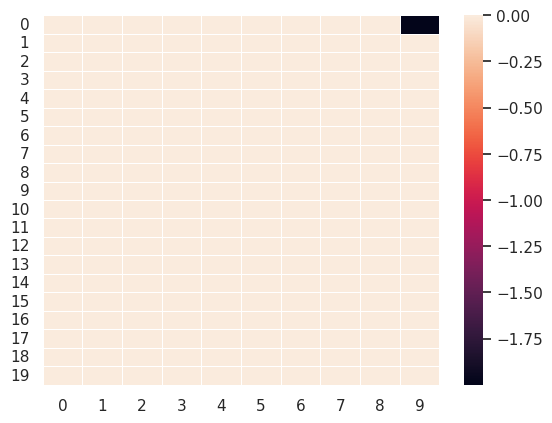

In [75]:
t_s = 200
i = 1
raw = np.fromfile(f"{prob}.stencil.data", dtype)[i * t_s:(i+1)*t_s]
sns.heatmap(raw.reshape((20,10)), linewidth=0.5)

<AxesSubplot:>

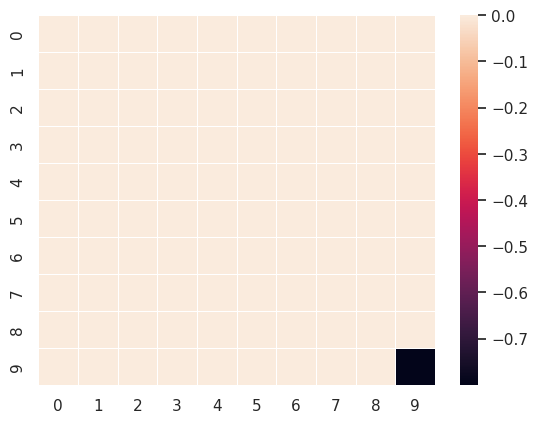

In [10]:

r0 = raw[:prod(dims)//2].reshape((20,10))
r1 = raw[prod(dims)//2:].reshape((20,10))

new_data = np.zeros((20,20))
new_data[:,:10] = r0
new_data[:,10:] = r1

<AxesSubplot:>

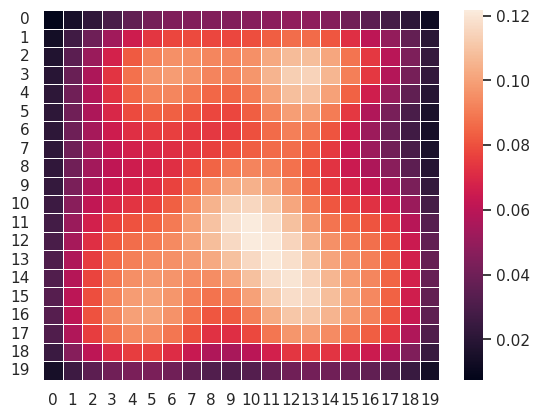

In [11]:
sns.heatmap(new_data, linewidth=0.5)

[Text(0.5, 1.0, 'raw output')]

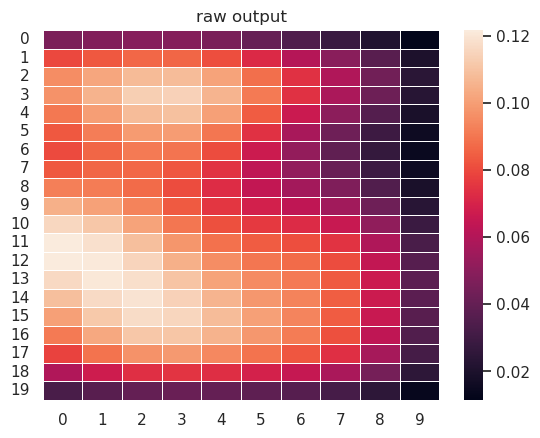

In [12]:
g=sns.heatmap(np.fromfile(f"{prob}.stencil.data", dtype)[200:400].reshape((20,10)), linewidths=.5)
g.set(title='raw output')

In [13]:
orig[...,0:orig.shape[0]//2] = 1
orig[...,orig.shape[0]//2:] = 2
orig.tofile('2d5pt.input.data-split')

In [14]:
for index, values in np.ndenumerate(orig):
    orig[index] = index[0] * 100 + index[1]
    
orig.tofile('2d5pt.input.data-split')

<AxesSubplot:>

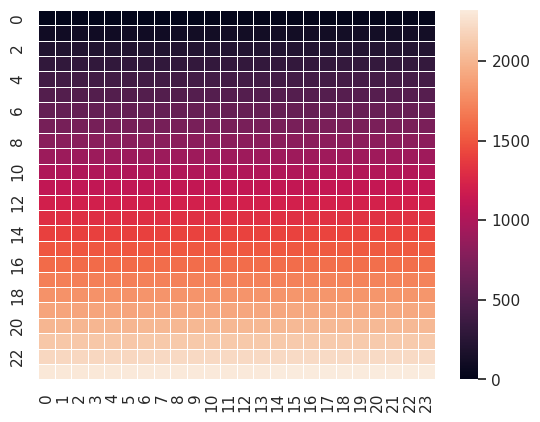

In [15]:
sns.heatmap(orig, linewidths=.5)

In [16]:
r0 = np.fromfile('2d5pt.stencil.data.rank0', dtype).reshape((24,24))
r1 = np.fromfile('2d5pt.stencil.data.rank1', dtype).reshape((24,24))

<AxesSubplot:>

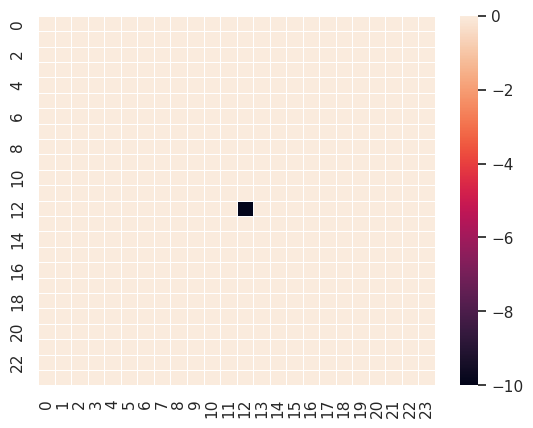

In [17]:
sns.heatmap(r0, linewidths=.5)

<AxesSubplot:>

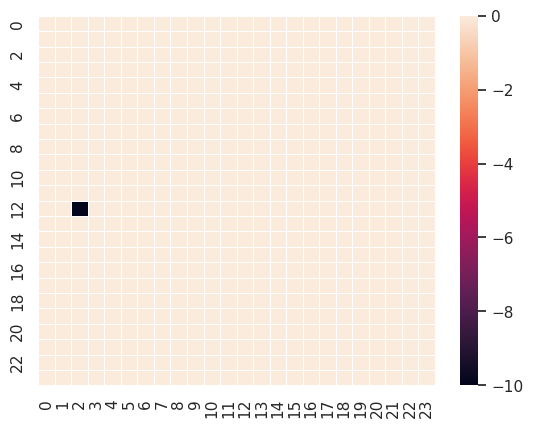

In [18]:
sns.heatmap(r1, linewidths=.5)

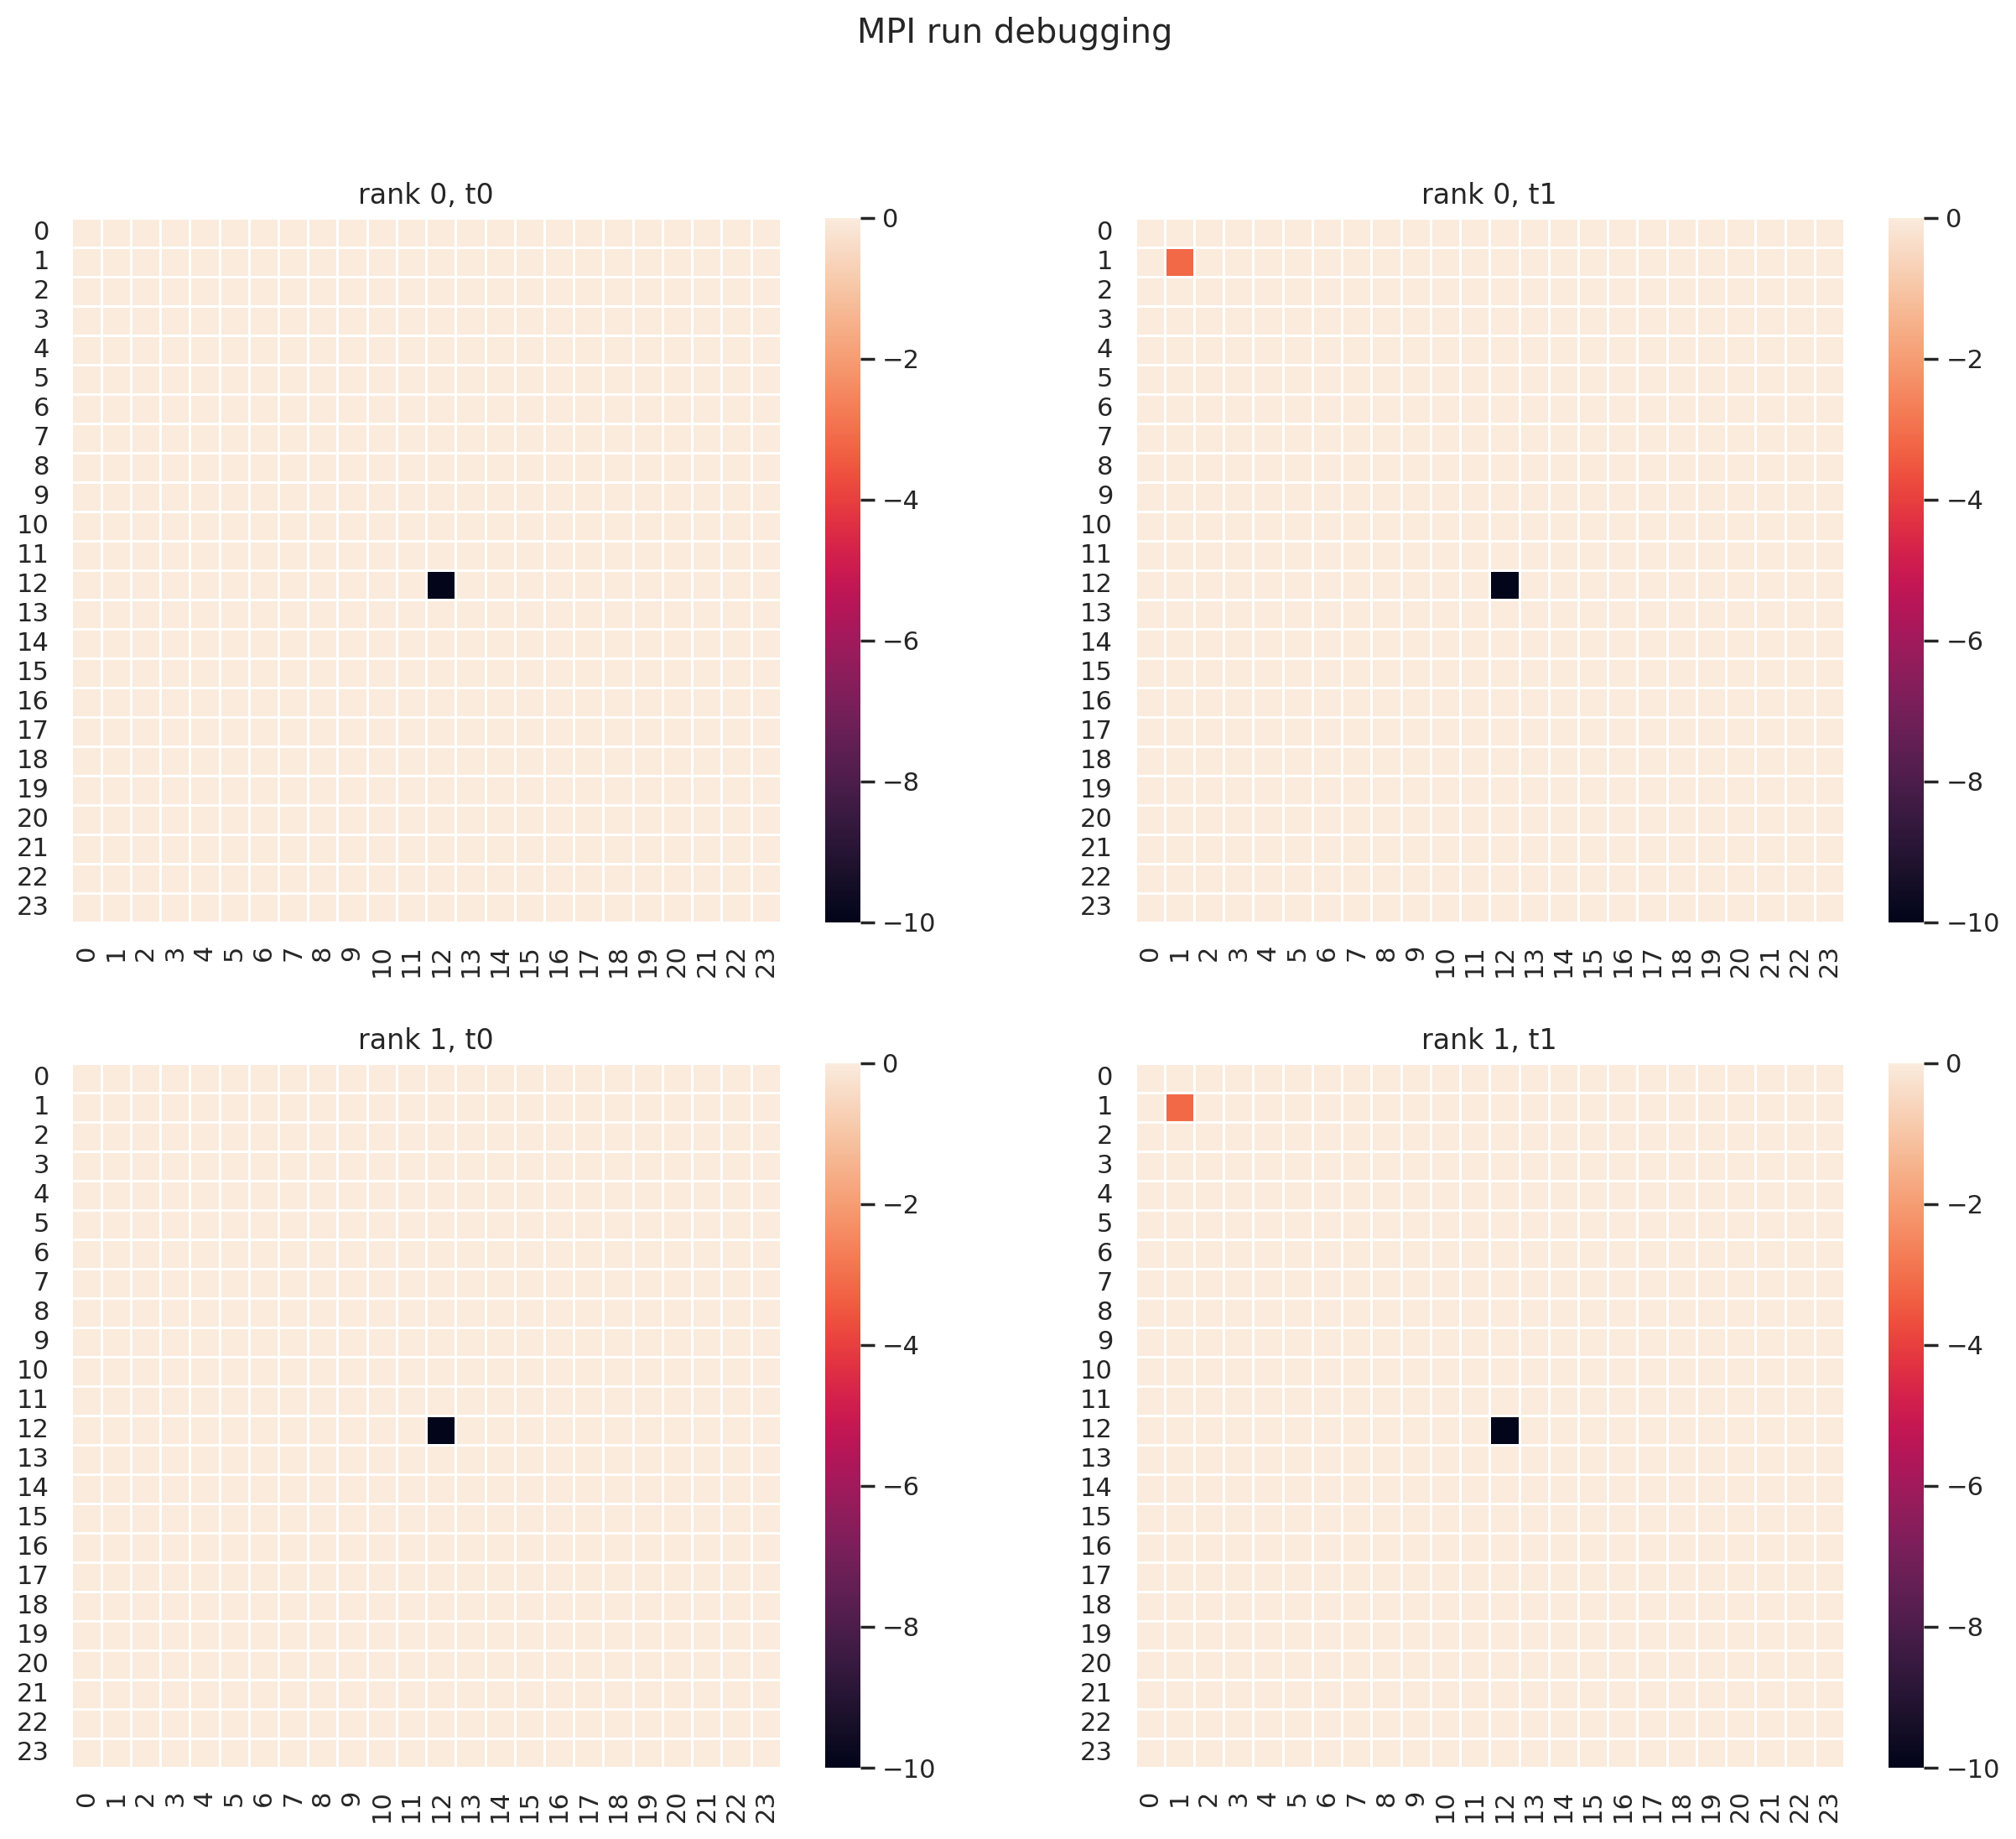

In [19]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15, 12), dpi=200)

axis = iter([ax1, ax2, ax3, ax4])
                         
for node in (0,1):
    for buff in (0,1):
        d = np.fromfile(f'result-rank-{node}-buff-{buff}.data', dtype=dtype).reshape((24,24))
        g = sns.heatmap(d, linewidth=0.5,ax=next(axis))
        g.set(title=f"rank {node}, t{buff}")
        tl = g.get_xticklabels()
        g.set_xticklabels(tl, rotation=90)
        tly = g.get_yticklabels()
        g.set_yticklabels(tly, rotation=0)

f.suptitle('MPI run debugging')
plt.show()